In [227]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from data import load_traindata
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.optim.lr_scheduler import LambdaLR
from augmentation import augment 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset

In [228]:
torch.manual_seed(42)

15 - 64% on 0.05M 200 classes
30 -     on 0.05M 200 classes

In [229]:
split_size = 0.75
batch_size = 32
num_subclasses = 300
learning_rate = 3e-4
epochs = 200
test_epochs = 10
seq_size = 250
n_block = 4
channel_size = 12
num_aug = 10

In [230]:
def plotWave(X):
   # Create a common time axis for all leads
    time = torch.arange(0, X.size(0))
    num_leads = 3
    # Create subplots (12 rows, 1 column)
    fig, axes = plt.subplots(num_leads, 1, figsize=(10, 24), sharex=True, sharey=True)
    fig.suptitle(str(num_leads) + ' Lead ECG Report', fontsize=16)

    # Plot each lead in a separate subplot
    for i in range(num_leads):
        axes[i].plot(time, X[:, i].numpy(), color='b')
        axes[i].set_ylabel(f'Lead {i+1}')
        axes[i].grid(True)

    # Set common X-axis label for time
    axes[num_leads-1].set_xlabel('Time')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [231]:
def zero_index_encode(Y: torch.Tensor, unique_labels: torch.Tensor) -> torch.Tensor:
    """
    Encode labels in Y to 0-based indices using unique_labels.

    Parameters:
    - Y: Tensor of original labels (e.g., [10, 30, 20])
    - unique_labels: Tensor of unique labels sorted (e.g., [10, 20, 30])

    Returns:
    - Tensor of encoded labels (e.g., [0, 2, 1])
    """
    # Create mapping from label to index
    label_to_index = {label.item(): idx for idx, label in enumerate(unique_labels)}
    return torch.tensor([label_to_index[y.item()] for y in Y], dtype=torch.long)

def zero_index_decode(Y_encoded, unique_labels):
    """
    Decode 0-based index labels back to their original class labels using unique_labels.
    
    Parameters:
    - Y_encoded: Tensor or list of encoded indices (e.g., [0, 2, 1])
    - unique_labels: List or tensor of original label values (e.g., [10, 20, 30])
    
    Returns:
    - Tensor of decoded original labels (e.g., [10, 30, 20])
    """
    index_to_label = list(unique_labels)
    return torch.tensor([index_to_label[idx] for idx in Y_encoded], dtype=torch.long)

def shuffle_data(X, Y):
    assert len(X) == len(Y)
    indices = torch.randperm(len(X))
    return X[indices], Y[indices]



In [232]:
#load dataset
X,Y = load_traindata(num_subclasses)
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
X = X.reshape(int(num_subclasses), int(1000 / seq_size), seq_size, 12)

unique_labels = Y.unique()
sampling_rate = 100
segments_per_class = int(10 * sampling_rate * split_size / seq_size) #3
test_segments_per_class = int(10 * sampling_rate * (1 - split_size) / seq_size) #1
#X, Y = shuffle_data(X, Y)

X_train = X[:, :segments_per_class, :,:] #100,3,250,12
X_train = X_train.reshape(num_subclasses*segments_per_class, seq_size, 12) #300, 250 , 12
X_test = X[:, segments_per_class:, :,:] #100,1,250,12
Y_train = Y 
Y_test = Y
X_aug, Y_aug = augment(X_train, Y_train, num_masks=num_aug)

X_test = X_test.reshape(num_subclasses, test_segments_per_class, seq_size, 12)
X_test = X_test.reshape(num_subclasses * test_segments_per_class, seq_size, 12)
Y_test = zero_index_encode(Y_test, unique_labels) 
Y_test = Y_test.repeat_interleave(test_segments_per_class, dim=0) #300 
Y_test = Y_test.reshape(num_subclasses * test_segments_per_class)
#X_aug = X_aug.view(num_subclasses, segments_per_class * (2*num_aug + 1),seq_size,12) #reshape after split
#X_aug = X_aug.view(num_subclasses*((2*num_aug + 1))*segments_per_class,seq_size,12)
Y_aug = zero_index_encode(Y_aug, unique_labels)
Y_train = zero_index_encode(Y_train, unique_labels)
X = X.reshape(num_subclasses * 4, seq_size, 12)
Y = zero_index_encode(Y, unique_labels)
Y = Y.repeat_interleave(4, dim=0) #300
print(X.shape, Y.shape)

/var/folders/g6/f8dm2s3j49v8_h2b1tdytvmr0000gn/T/ipykernel_24581/1581479567.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)


torch.Size([1200, 250, 12]) torch.Size([1200])


In [233]:
print(X_aug.shape, Y_aug.shape)
assert(X_aug.shape[0]==Y_aug.shape[0])
print(X_test.shape, Y_test.shape)
assert(X_test.shape[0]==Y_test.shape[0])

torch.Size([18900, 250, 12]) torch.Size([18900])
torch.Size([300, 250, 12]) torch.Size([300])


In [234]:
class ECGDataset(Dataset):
    def __init__(self,X,Y):  
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[:,:,1][idx], self.Y[idx] #second lead
        #return self.X[idx], self.Y[idx]

In [235]:
testing_data = ECGDataset(X_test,Y_test)
dataset = ECGDataset(X_aug,Y_aug)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

In [236]:
#CONV1D model for 2nd Lead
#100, 70
class Model(nn.Module):
    def __init__(self, num_filters = 16):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv1d(1, num_filters, 4, 1, 2),  # 250 →250 (after padding), then 250 →125 after pool
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.5),
        )
        self.enc2 = nn.Sequential(
            nn.Conv1d(num_filters, num_filters * 2, 4, 1, 2),  # 125 →125 →63
            nn.BatchNorm1d(num_filters * 2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.5),
        )
        # self.enc3 = nn.Sequential(
        #     nn.Conv1d(num_filters * 2, num_filters * 4, 4, 1, 2),  # 63 →63 →32
        #     nn.BatchNorm1d(num_filters * 4),
        #     nn.ReLU(),
        #     nn.MaxPool1d(2),
        #     nn.Dropout(0.5),
        # )
        # self.enc4 = nn.Sequential(
        #     nn.Conv1d(num_filters * 4, num_filters * 8, 4, 1, 2),  # 32 →32 →16
        #     nn.BatchNorm1d(num_filters * 8),
        #     nn.ReLU(),
        #     nn.MaxPool1d(2),
        #     nn.Dropout(0.5),
        # )
        # self.enc5 = nn.Sequential(
        #     nn.Conv1d(num_filters * 8, num_filters * 16, 4, 1, 2),  # 16 → 8
        #     nn.BatchNorm1d(num_filters * 16),
        #     nn.ReLU(),
        #     nn.MaxPool1d(2),
        #     nn.Dropout(0.2),
        # )
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_subclasses)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension at index 1
        x = self.enc1(x)
        x = self.enc2(x)
        #x = self.enc3(x)
        #x = self.enc4(x)
        # x = self.enc5(x)
        x = self.global_max_pool(x)
        x = x.squeeze(2)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [237]:
import torch
import torch.nn as nn

class SimpleCNN1D(nn.Module):
    def __init__(self, num_subclasses=num_subclasses, num_filters=16):
        super(SimpleCNN1D, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=5, stride=1, padding=2),  # preserves input length
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # Downsample by 2

            nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=num_filters*2, out_channels=num_filters*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        self.global_max_pool = nn.AdaptiveMaxPool1d(1)  # (B, C, 1)
        self.classifier = nn.Sequential(
            nn.Flatten(),  # (B, C)
            nn.Linear(num_filters*4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_subclasses)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # shape: (B, 1, L)
        x = self.conv_block(x)
        x = self.global_max_pool(x)
        x = self.classifier(x)
        return x


In [238]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=1,   
            hidden_size=50,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(100, num_subclasses)
    def forward(self, x):
        x = x.unsqueeze(2)
        x, _ = self.bilstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.dropout(x)
        return x

In [239]:
#model = Model()
model = SimpleCNN1D()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
losses = []

0.055916 M parameters


In [240]:
def warmup_then_decay(epoch, warmup_epochs=10, total_epochs=epochs):
    if epoch < warmup_epochs:
        return epoch / warmup_epochs  # Linear warm-up
    else:
        decay_factor = 0.1 ** ((epoch - warmup_epochs) / (total_epochs - warmup_epochs))
        return decay_factor
    

def getaccuracy(loader, model, dataset_name=""):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in loader:
            data = torch.tensor(data, dtype=torch.float32)
            data = data.to(device)
            labels = labels.to(device).long()  # Labels should be integer class indices
            outputs = model(data)  # e.g., shape (batch_size, num_classes)

            # Get predicted class by taking argmax over class dimension
            _, predicted = torch.max(outputs, dim=1)  # same as outputs.argmax(dim=1)

            # Compare predictions to true labels
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    print(f'Accuracy on {dataset_name} dataset: {accuracy:.2f}%')



In [241]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
models = []
dataset_all = TensorDataset(X_aug[:,:,1], Y_aug)
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset_all)):
    print(f"\n--- Fold {fold+1}/{5} ---")
    train_subset = Subset(dataset_all, train_idx)
    val_subset = Subset(dataset_all, val_idx)
    print(len(train_subset), len(val_subset))

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = SimpleCNN1D().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        length = 0

        for x, y in train_loader:
            x, y = x.to(torch.float32).to(device), y.to(torch.long).to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            length += len(y)

        if (epoch+1) % test_epochs == 0:
            print(f"Epoch {epoch+1}, Train Loss: {total_loss/length:.4f}")
            getaccuracy(train_loader, model, "train")
            getaccuracy(val_loader, model, "val")

    # Final validation accuracy for the fold
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(torch.float32).to(device), y.to(torch.long).to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    acc = 100 * correct / total
    fold_accuracies.append(acc)
    models.append(model)
    print(f"Fold {fold+1} Accuracy: {acc:.2f}%")



--- Fold 1/5 ---
15120 3780
Epoch 10, Train Loss: 0.0774


/var/folders/g6/f8dm2s3j49v8_h2b1tdytvmr0000gn/T/ipykernel_24581/1093280786.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


Accuracy on train dataset: 47.22%
Accuracy on val dataset: 44.42%
Epoch 20, Train Loss: 0.0509
Accuracy on train dataset: 78.71%
Accuracy on val dataset: 76.98%
Epoch 30, Train Loss: 0.0379
Accuracy on train dataset: 88.06%
Accuracy on val dataset: 86.01%
Epoch 40, Train Loss: 0.0320
Accuracy on train dataset: 94.35%
Accuracy on val dataset: 92.46%
Epoch 50, Train Loss: 0.0275
Accuracy on train dataset: 95.86%
Accuracy on val dataset: 94.13%
Epoch 60, Train Loss: 0.0249
Accuracy on train dataset: 97.41%
Accuracy on val dataset: 95.63%
Epoch 70, Train Loss: 0.0218
Accuracy on train dataset: 98.08%
Accuracy on val dataset: 97.12%
Epoch 80, Train Loss: 0.0199
Accuracy on train dataset: 98.29%
Accuracy on val dataset: 97.65%
Epoch 90, Train Loss: 0.0184
Accuracy on train dataset: 98.88%
Accuracy on val dataset: 97.59%
Epoch 100, Train Loss: 0.0175
Accuracy on train dataset: 98.63%
Accuracy on val dataset: 97.59%
Epoch 110, Train Loss: 0.0162
Accuracy on train dataset: 99.33%
Accuracy on va

In [242]:
for x in models:    
    getaccuracy(test_loader, x, "test")

/var/folders/g6/f8dm2s3j49v8_h2b1tdytvmr0000gn/T/ipykernel_24581/1093280786.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


Accuracy on test dataset: 83.00%
Accuracy on test dataset: 85.33%
Accuracy on test dataset: 79.67%
Accuracy on test dataset: 84.67%
Accuracy on test dataset: 86.33%


In [243]:
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-4)
#scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: warmup_then_decay(epoch))
for epoch in range(epochs):
    if (epoch+1) % test_epochs == 0:
        print(f'Epoch {epoch}, loss: {total_loss/length:.4f}')
        getaccuracy(dataloader,m, "train")
        getaccuracy(test_loader,m, "test")
    total_loss = 0
    length = 0
    for x, y in dataloader:
        x,y = x.to(torch.float32), y.to(torch.float32)
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        out = m(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        length += len(y)
    losses.append(total_loss/length)
    #scheduler.step()

Epoch 9, loss: 0.0975


/var/folders/g6/f8dm2s3j49v8_h2b1tdytvmr0000gn/T/ipykernel_24581/1093280786.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


Accuracy on train dataset: 21.69%
Accuracy on test dataset: 17.33%
Epoch 19, loss: 0.0150
Accuracy on train dataset: 87.52%
Accuracy on test dataset: 58.33%
Epoch 29, loss: 0.0043
Accuracy on train dataset: 96.13%
Accuracy on test dataset: 64.67%
Epoch 39, loss: 0.0016
Accuracy on train dataset: 98.08%
Accuracy on test dataset: 65.00%
Epoch 49, loss: 0.0017
Accuracy on train dataset: 99.08%
Accuracy on test dataset: 66.67%
Epoch 59, loss: 0.0011
Accuracy on train dataset: 98.60%
Accuracy on test dataset: 64.00%
Epoch 69, loss: 0.0011
Accuracy on train dataset: 99.69%
Accuracy on test dataset: 67.33%
Epoch 79, loss: 0.0002
Accuracy on train dataset: 99.59%
Accuracy on test dataset: 70.67%
Epoch 89, loss: 0.0006
Accuracy on train dataset: 99.67%
Accuracy on test dataset: 70.00%
Epoch 99, loss: 0.0006
Accuracy on train dataset: 99.97%
Accuracy on test dataset: 70.67%
Epoch 109, loss: 0.0000
Accuracy on train dataset: 100.00%
Accuracy on test dataset: 72.67%
Epoch 119, loss: 0.0003
Accurac

tensor(208) tensor(208)


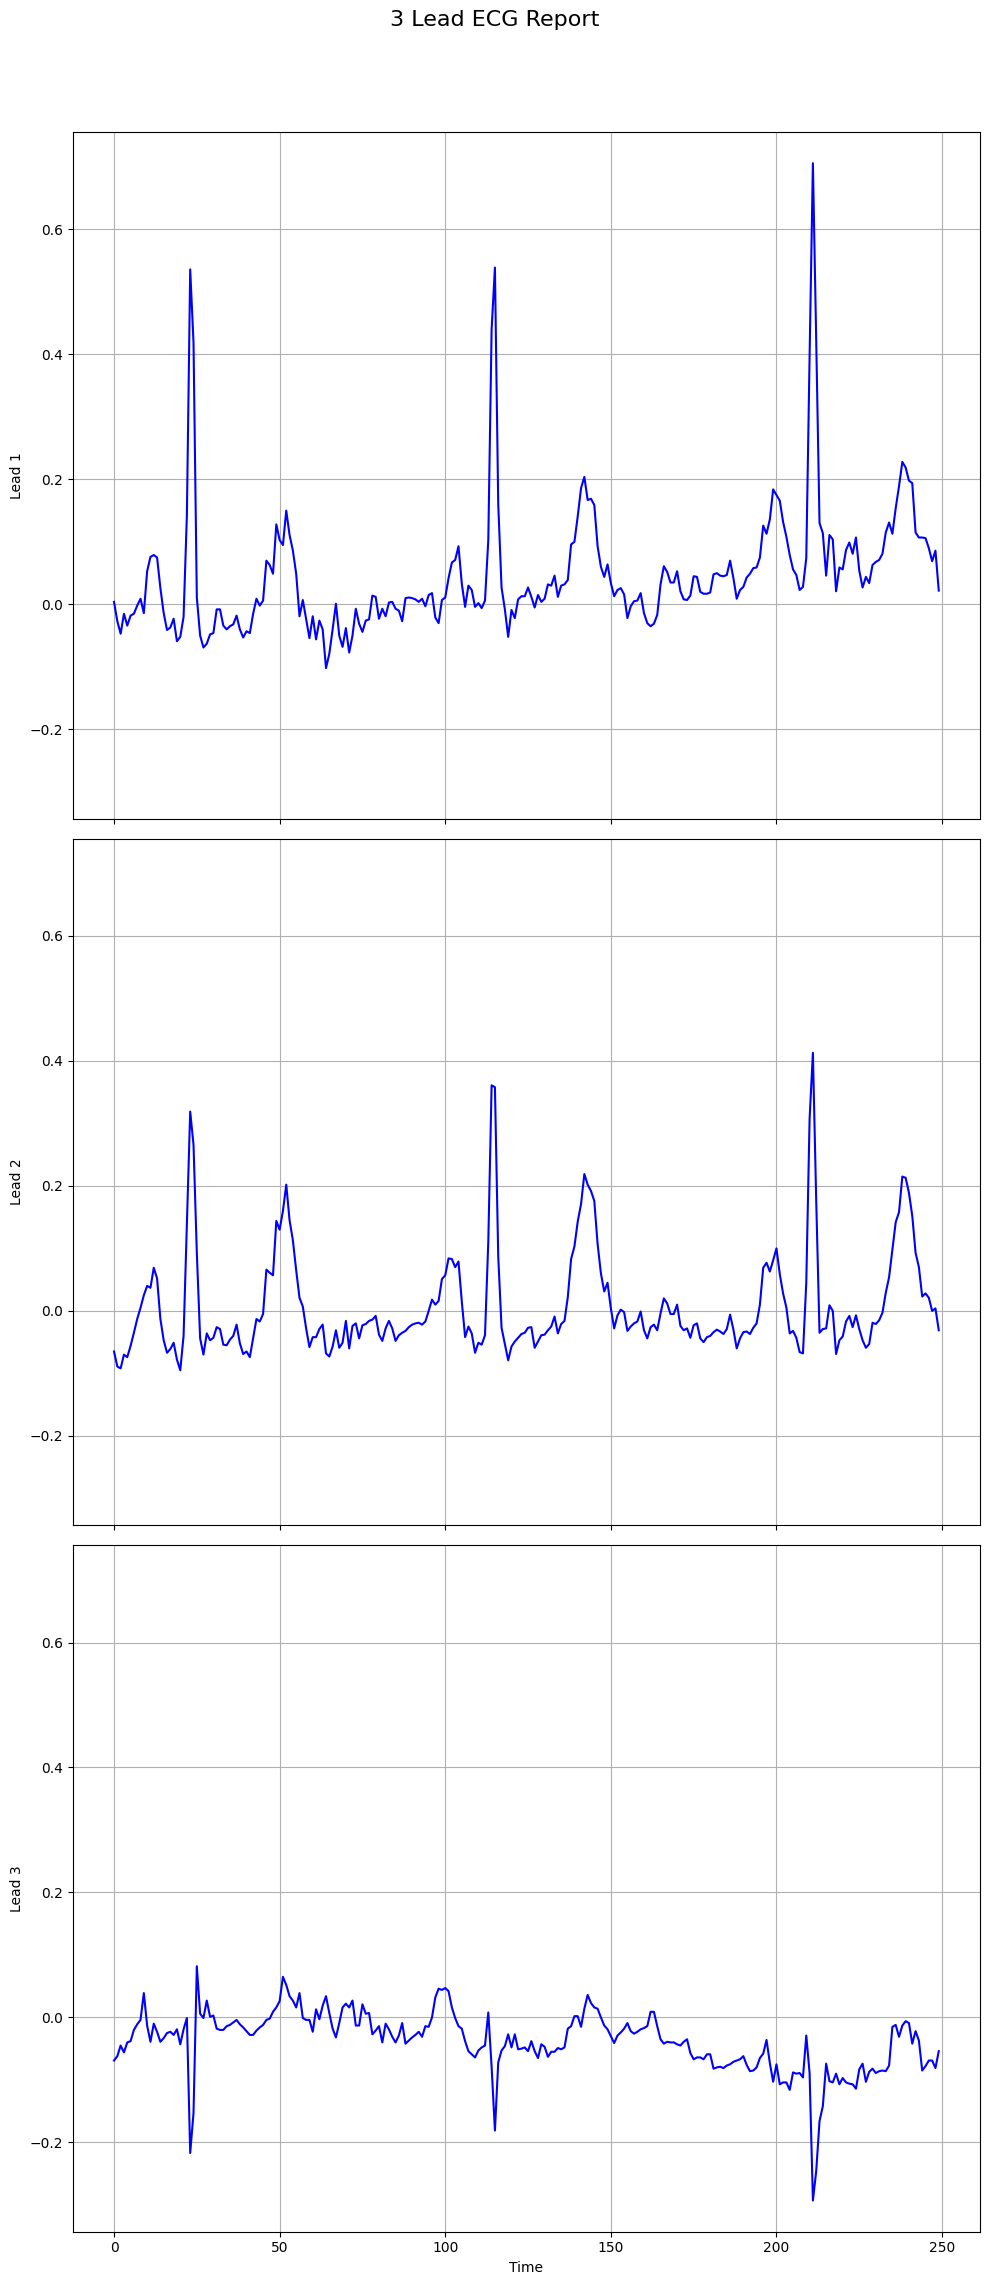

In [244]:
print(Y_aug[0], Y_test[0])
plotWave(X_test[0])

In [245]:
#DATASET CHECK
print(Y_aug[0],Y_aug[35], Y_aug[70], Y_aug[107])

tensor(208) tensor(208) tensor(163) tensor(163)


In [246]:
idx = 30
ip = X_test[idx][:,1].reshape(1,seq_size).to(device)
print(ip.shape)
print(Y_test[idx])
out = m(ip)
print(torch.max(out, dim=1))

torch.Size([1, 250])
tensor(266)
torch.return_types.max(
values=tensor([23.1445], device='mps:0', grad_fn=<MaxBackward0>),
indices=tensor([266], device='mps:0'))


In [247]:
out.shape
print(out[0][130])

tensor(9.6252, device='mps:0', grad_fn=<SelectBackward0>)
